In [44]:
# author: Zhuo Shen

In [45]:
import torch
print("Using torch", torch.__version__)
import numpy as np
import os
import time
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.autograd import grad
import torch.utils.data as data

import matplotlib.pyplot as plt

%matplotlib inline

Pi = np.pi

Using torch 2.0.1+cu118


In [46]:
dev = torch.device("cuda")

In [47]:
# if torch.backends.mps.is_available():
#     dev = torch.device("mps")
#     mps_device = torch.device("mps")
# else:
#     dev = torch.device("cpu")
#     print ("MPS device not found. Use CPU instead")

In [48]:
#a very simple torch method to compute derivatives.
def nth_derivative(f, wrt, n):
    for i in range(n):
        grads = grad(f, wrt, create_graph=True, allow_unused=True)[0]
        f = grads.sum()
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads

In [49]:
# This class is a general Neural Network (fully connected, feed forward neural network), a.k.a Multi Layer Perceptron (MLP)
# Our PINN will be represented by a neural network of this type
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.il  = nn.Linear(3,20)
        self.hl1  = nn.Linear(20,200)
        self.hl2 = nn.Linear(200,200)
        self.hl3 = nn.Linear(200,200)
        self.hl4 = nn.Linear(200,200)
        self.hl5 = nn.Linear(200,20)
        self.ol  = nn.Linear(20,1)

        self.tn  = nn.Tanh()

    def forward(self, x, y, t):
        u = torch.cat((x, y, t), 1)
        u = self.il(u)
        u = self.hl1(self.tn(u))
        u = self.hl2(self.tn(u))
        u = self.hl3(self.tn(u))
        u = self.hl4(self.tn(u))
        u = self.hl5(self.tn(u))
        u = self.ol(u)
        return u

In [50]:
# Parameters
Vlid = 1.0;
Lx = 2.0; Ly = 1.0;     # cavity dimensions
visc = 0.01; # viscosity
rho = 1.0; # density
Lt = 20; # total time


class Equation_Container():

    def setter(self, x,y,t,model):
        self.x = x
        self.y = y
        self.t = t
        self.model = model
        self.psi = self.model(self.x, self.y, self.t)
    def stream_function(self):
        return self.psi

    def x_velocity(self):
        psi_y = nth_derivative(self.psi.sum(), self.y, 1)
        return psi_y

    def y_velocity(self):
        psi_x = nth_derivative(self.psi.sum(), self.x, 1)
        return -psi_x

    def vorticity(self):
        psi_xx = nth_derivative(self.psi.sum(), self.x, 2)
        psi_yy = nth_derivative(self.psi.sum(), self.y, 2)
        return -psi_xx - psi_yy

    def evolution_equation(self):
        w = self.vorticity()

        w_t = nth_derivative(w.sum(), self.t, 1)
        w_x = nth_derivative(w.sum(), self.x, 1)
        w_y = nth_derivative(w.sum(), self.y, 1)
        w_xx = nth_derivative(w.sum(), self.x, 2)
        w_yy = nth_derivative(w.sum(), self.y, 2)

        u_x = self.x_velocity()
        u_y = self.y_velocity()

        f = -w_t - u_x*w_x - u_y*w_y + visc*(w_xx + w_yy)
        return f

In [51]:
class BC_Data(data.Dataset):
    def __init__(self, nx, ny, nt):
        """
        Inputs:
            nx - number of points used to sample boundary conditions in x
            ny - number of points used to sample boundary conditions in y
            nt - number of points used to sample boundary conditions in t
        """
        super().__init__()
        self.nx = nx
        self.ny = ny
        self.nt = nt
        self.generate_bc_data()

    def generate_bc_data(self):
        # u = (psi and y_velocity), or (x_velocity) as one chose
        # u(x,y,t=0) = 0
        x = np.linspace(0, Lx, self.nx)
        y = np.linspace(0, Ly, self.ny)
        t = np.linspace(0, Lt, self.nt)
        u = np.zeros((self.ny, self.nx))

        X,Y = np.meshgrid(x,y)
        x_bc = torch.from_numpy(X.reshape(-1)).float()
        y_bc = torch.from_numpy(Y.reshape(-1)).float()
        t_bc = torch.from_numpy(np.zeros(self.nx*self.ny)).float()
        u_bc = torch.from_numpy(u.reshape(-1)).float()

        # u(x=0, y,t) = 0
        Y,T = np.meshgrid(y,t)
        x_bc = torch.cat((x_bc, torch.from_numpy(np.zeros(self.ny*self.nt)).float()))
        y_bc = torch.cat((y_bc, torch.from_numpy(Y.reshape(-1)).float()))
        t_bc = torch.cat((t_bc, torch.from_numpy(T.reshape(-1)).float()))
        u_bc = torch.cat((u_bc, torch.from_numpy(np.zeros(self.ny*self.nt)).float()))

        # u(x, y=0,t) = 0
        X,T = np.meshgrid(x,t)
        x_bc = torch.cat((x_bc, torch.from_numpy(X.reshape(-1)).float()))
        y_bc = torch.cat((y_bc, torch.from_numpy(np.zeros(self.nx*self.nt)).float()))
        t_bc = torch.cat((t_bc, torch.from_numpy(T.reshape(-1)).float()))
        u_bc = torch.cat((u_bc, torch.from_numpy(np.zeros(self.nx*self.nt)).float()))

        # u(x=Lx, y,t) = 0
        x_bc = torch.cat((x_bc, torch.from_numpy(Lx*np.ones(self.ny*self.nt)).float()))
        y_bc = torch.cat((y_bc, torch.from_numpy(Y.reshape(-1)).float()))
        t_bc = torch.cat((t_bc, torch.from_numpy(T.reshape(-1)).float()))
        u_bc = torch.cat((u_bc, torch.from_numpy(np.zeros(self.ny*self.nt)).float()))

        # u(x, y=Ly,t) = 0 or Vlid
        x_bc = torch.cat((x_bc, torch.from_numpy(X.reshape(-1)).float())).reshape(-1,1)
        y_bc = torch.cat((y_bc, torch.from_numpy(Ly*np.ones(self.nx*self.nt)).float())).reshape(-1,1)
        t_bc = torch.cat((t_bc, torch.from_numpy(T.reshape(-1)).float())).reshape(-1,1)
        u_bc = torch.cat((u_bc, torch.from_numpy(np.zeros(self.nx*self.nt)).float())).reshape(-1,1)

        u_x_bc = u_bc.clone()
        u_x_bc[-self.nx*(self.nt-1):] = Vlid

        x_bc.requires_grad = True
        y_bc.requires_grad = True
        t_bc.requires_grad = True
        u_bc.requires_grad = False
        u_x_bc.requires_grad = False

        self.x = x_bc.to(dev)
        self.y = y_bc.to(dev)
        self.t = t_bc.to(dev)
        self.u = u_bc.to(dev)
        self.u_x = u_x_bc.to(dev)

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.u.shape[0]


class RandCollocationPoints(data.Dataset):

    def __init__(self, n_coll_pts):
        """
        Inputs:
            n_coll_pts - Number of randomly selected collocation points
        """
        super().__init__()
        self.n_coll_pts = n_coll_pts
        self.generate_coll_points()

    def generate_coll_points(self):

        x = np.random.uniform(0,Lx, self.n_coll_pts) # uniform random sampling of x between 0 and Lx
        y = np.random.uniform(0,Ly, self.n_coll_pts) # uniform random sampling of y between 0 and Ly
        t = np.random.uniform(0,Lt, self.n_coll_pts) # uniform random sampling of t between 0 and Lt

        x = torch.from_numpy(x).float().reshape(-1,1)
        y = torch.from_numpy(y).float().reshape(-1,1)
        t = torch.from_numpy(t).float().reshape(-1,1)

        x.requires_grad = True
        y.requires_grad = True
        t.requires_grad = True

        self.x = x.to(dev)
        self.y = y.to(dev)
        self.t = t.to(dev)

In [52]:
# Setting random seeds so that the results can be exactly reproduced
np.random.seed(88)
torch.random.manual_seed(88)

# Create Boundary condition data (object of the BC_Data class)
bc_data = BC_Data(nx = 10, ny = 10, nt = 10)

In [53]:
# Speed up training
torch.autograd.profiler.emit_nvtx(enabled=False)
torch.autograd.profiler.profile(enabled=False)

# Initialize nn_model
pinn = MLP().to(dev)
container = Equation_Container()

# Create empty lists to track optimization progress of the boundary conditions (L_bc) + optimization of PDE (L_pde)
L_bc_Di_evol = []
L_bc_Ne_evol = []
L_pde_evol = []

# Enforce the boundary condition with penalty coefficients
beta_Di = 1.0000
beta_Ne = 1.0000

miu_Di = 20
miu_Ne = 20
miu_PDE = 0.05

# Initialize optimizer -- Setting pinn parameters as the parameters to be optimized. Starting with a learning rate lr = 0.001 (good rule of thumb)
optimizer = optim.Adam(pinn.parameters(), lr=0.0002)
criterion = torch.nn.MSELoss()

num_epochs = 5001 # This sets the number of optimization iterations

for epoch in range(num_epochs):
    ###################################################################
    # Evaluate discrepancy relative to the Dirichlet boundary conditions (L_bc_Di)
    ###################################################################
    container.setter(bc_data.x, bc_data.y, bc_data.t, pinn)
    psi_at_bc_pts = container.stream_function() # evaluating psi at boundary
    L_bc_Di = criterion(psi_at_bc_pts, bc_data.u) # computing MSE between pinn and boundary condition values
    ###################################################################


    ###################################################################
    # Evaluate discrepancy relative to the Neumann boundary conditions (L_bc_Ne)
    ###################################################################
    ux_at_bc_pts = container.x_velocity() # evaluating x velocity at boundary
    L_bc_Ne_x = criterion(ux_at_bc_pts, bc_data.u_x)

    uy_at_bc_pts = container.y_velocity() # evaluating y velocity at boundary
    L_bc_Ne_y = criterion(uy_at_bc_pts, bc_data.u)

    L_bc_Ne = L_bc_Ne_x + L_bc_Ne_y
    ###################################################################


    ###################################################################
    # Evaluate discrepancy relative to the Evolution PDE (L_PDE)
    ###################################################################
    coll_pts = RandCollocationPoints(n_coll_pts = 1000) # randomly select n_coll_pts = 1000 within the domain
    # container.setter(torch.cat((bc_data.x,coll_pts.x)), torch.cat((bc_data.y,coll_pts.y)), torch.cat((bc_data.t,coll_pts.t)), pinn)
    container.setter(coll_pts.x, coll_pts.y, coll_pts.t, pinn)
    pde_at_coll_pts = container.evolution_equation()

    L_pde = criterion(pde_at_coll_pts, torch.zeros(pde_at_coll_pts.shape).to(dev)) # computing mean squared error of the PDE residuals
    # L_pde = torch.tensor([0]).to(dev)
    ###################################################################


    ###################################################################
    # Optimize PINN parameters
    ###################################################################
    miu_Di = miu_Di*beta_Di  # update penalty coefficients
    miu_Ne = miu_Ne*beta_Ne
    L_bc_pde = miu_Di*L_bc_Di + miu_Ne*L_bc_Ne + miu_PDE*L_pde # Combine the boundary condition and PDE residuals

    # Now we optimize (always done by these 3 steps):
    optimizer.zero_grad(set_to_none=True) # set all gradients previously calculated to None
    L_bc_pde.backward() # compute gradient of our objective function (that we want to minimize) with respect to the parameters of the PINN
    optimizer.step() # update the parameters of the PINN according to gradient descent
    ###################################################################

    # Append L_bc and L_pde values to track their evolution
    L_bc_Di_evol.append(L_bc_Di.item())
    L_bc_Ne_evol.append(L_bc_Ne.item())
    L_pde_evol.append(L_pde.item())

    if (epoch % 500 == 0) or (epoch == num_epochs-1):
        print('epoc = ', epoch)
        print('loss = ', float(L_bc_pde))
    if epoch % 2500 == 0 and epoch != 0: # uncomment this line to save model
        torch.save(pinn.state_dict(), 'Flow_in_Cavity.pt') # uncomment this line to save model


epoc =  0
loss =  3.6259961128234863
epoc =  500
loss =  1.7727984189987183
epoc =  1000
loss =  1.4492173194885254
epoc =  1500
loss =  0.9299327731132507
epoc =  2000
loss =  0.5596190690994263
epoc =  2500
loss =  0.5310465097427368
epoc =  3000
loss =  0.48703014850616455
epoc =  3500
loss =  0.48356857895851135
epoc =  4000
loss =  0.47684672474861145
epoc =  4500
loss =  0.4735943675041199
epoc =  5000
loss =  0.4823290705680847


In [54]:
coll_pts = RandCollocationPoints(n_coll_pts = 1000) # randomly select n_coll_pts = 1000 in the domain
# container.setter(torch.cat((bc_data.x,coll_pts.x)), torch.cat((bc_data.y,coll_pts.y)), torch.cat((bc_data.t,coll_pts.t)), pinn)
container.setter(coll_pts.x, coll_pts.y, coll_pts.t, pinn)
pde_at_coll_pts = container.evolution_equation()

L_pde = criterion(pde_at_coll_pts, torch.zeros(pde_at_coll_pts.shape).to(dev)) # computing mean squared error of the PDE residuals
L_pde

tensor(0.3444, device='cuda:0', grad_fn=<MseLossBackward0>)

In [55]:
L_bc_Ne_evol[-1]

0.02280406840145588

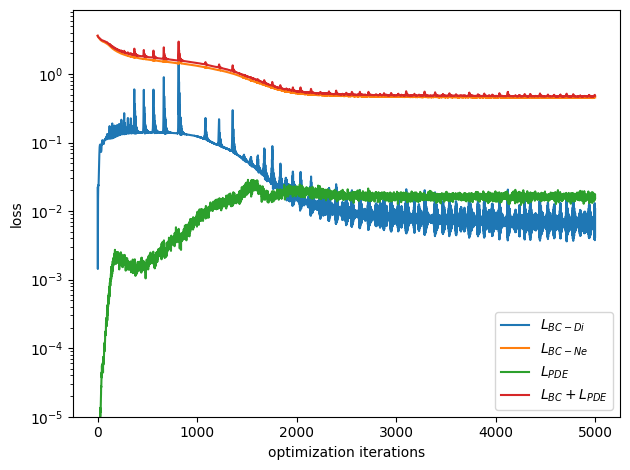

In [56]:
plt.semilogy(miu_Di*np.array(L_bc_Di_evol), label = r'$L_{BC-Di}$')
plt.semilogy(miu_Ne*np.array(L_bc_Ne_evol), label = r'$L_{BC-Ne}$')
plt.semilogy(miu_PDE*np.array(L_pde_evol), label = r'$L_{PDE}$')
plt.semilogy(miu_Di*np.array(L_bc_Di_evol) + miu_Ne*np.array(L_bc_Ne_evol) + miu_PDE*np.array(L_pde_evol), label = r'$L_{BC}+L_{PDE}$')
plt.ylabel('loss')
plt.xlabel('optimization iterations')
plt.ylim(1e-5,)
plt.legend()
plt.tight_layout()

In [59]:
# from google.colab import files
# files.download('Flow_in_Cavity.pt')

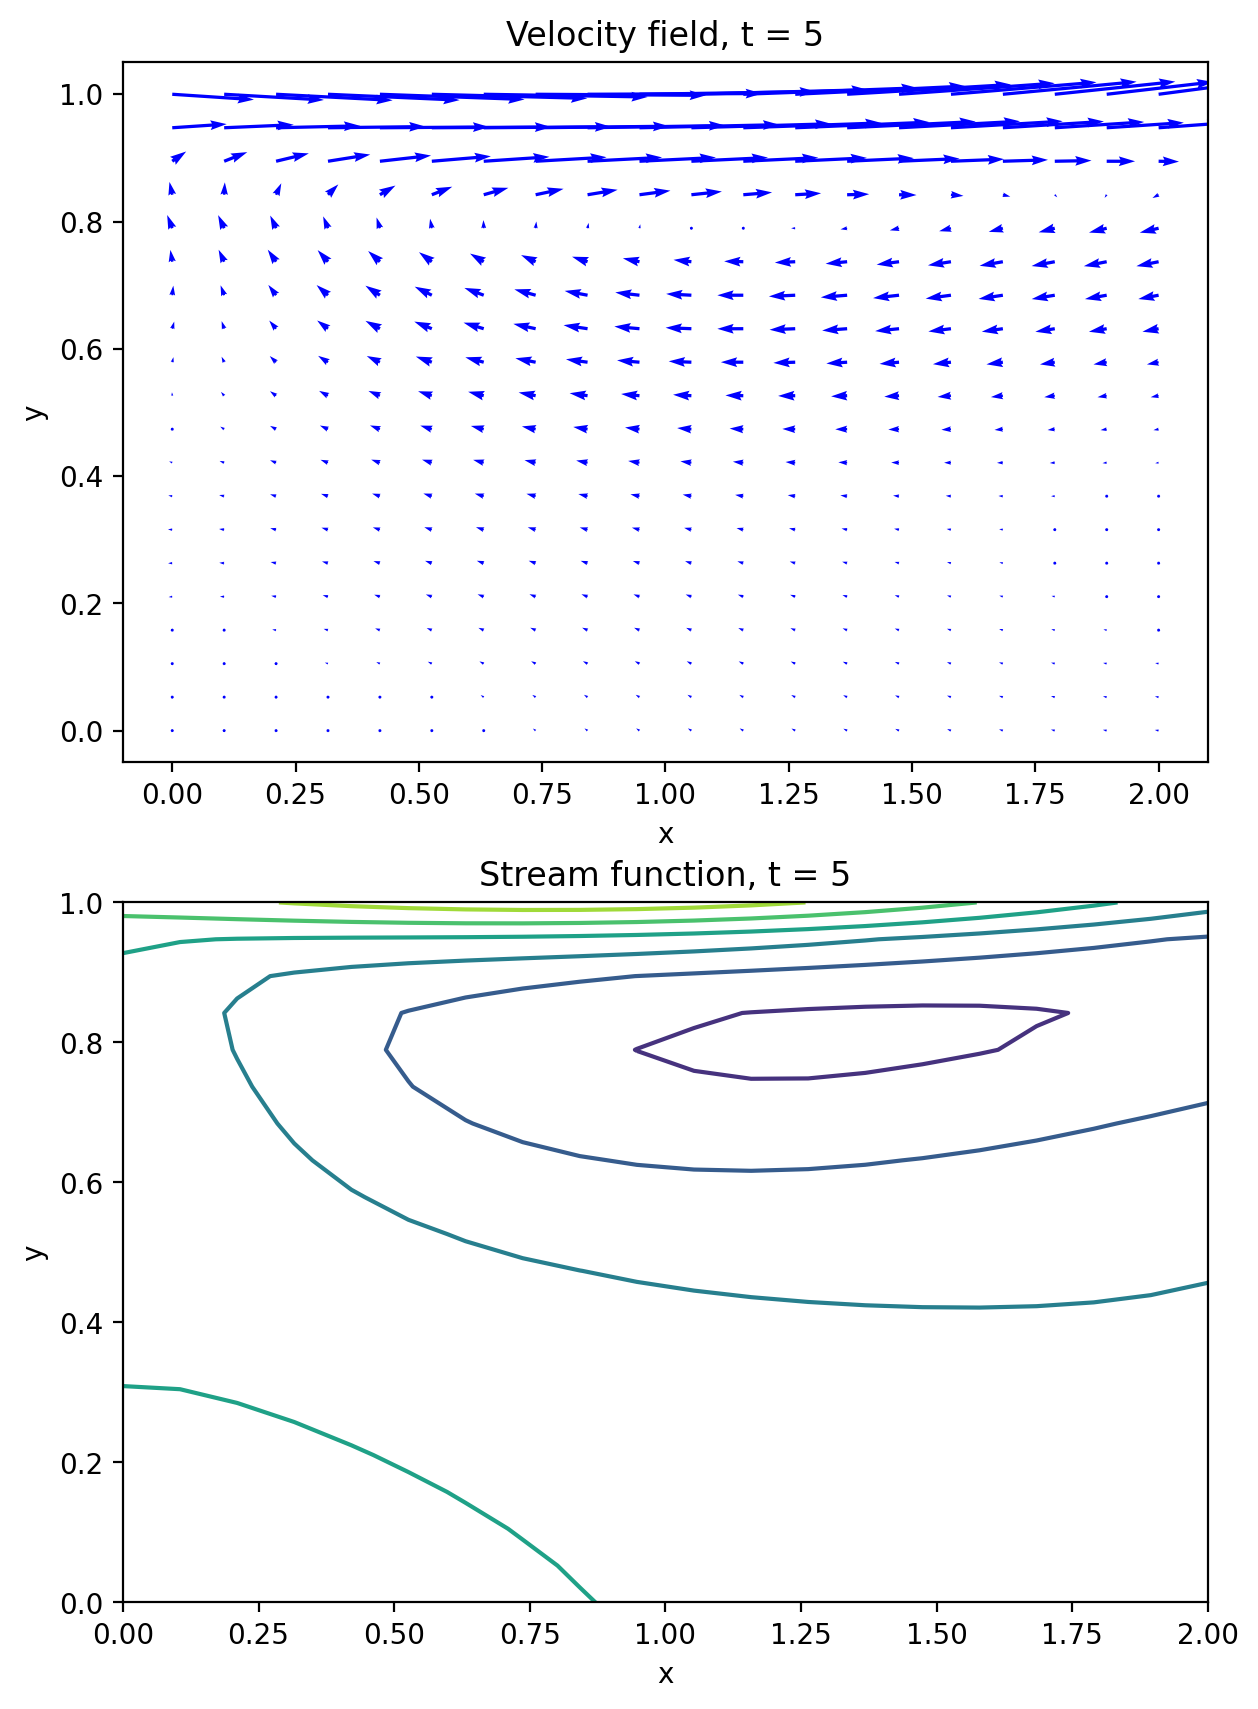

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
vxn = 20
vyn = 20
vtn = 20
vx = np.linspace (0, Lx, vxn)
vy = np.linspace (0, Ly, vyn)
vt = np.linspace (0, Lt, vtn)
Vx, Vy = np.meshgrid(vx,vy)
Vx = torch.FloatTensor(Vx.flatten().reshape(-1,1))
Vy = torch.FloatTensor(Vy.flatten().reshape(-1,1))
Vt = (5*torch.from_numpy(np.ones(vxn*vyn))).reshape(-1,1).float()

fig, ax = plt.subplots(2,1, figsize = (7,10), dpi = 200)

u_test = model(Vx, Vy, Vt).reshape(vxn,vyn)
u_test = u_test.detach().numpy()

ux = np.gradient(u_test, vy, axis = 0)
uy = -np.gradient(u_test, vx, axis = 1)

ax[0].quiver(vx, vy, ux, uy, color='blue', scale=5)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Velocity field, t = 5')

ax[1].contour(Vx.detach().numpy().reshape(20,20), Vy.detach().numpy().reshape(20,20), u_test)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Stream function, t = 5')

plt.savefig('cavity_PINN.png')
plt.show()

from google.colab import files
files.download('cavity_PINN.png')